In [1]:
import os
import gzip
import base64
from glob import glob
from dataclasses import dataclass
import gc
import numpy as np
from numpy.linalg import norm
import pandas as pd
import PIL
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import transforms
from transformers import ViTImageProcessor, AutoModel
from tqdm import tqdm
import xgboost as xgb
import timm

import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import mean_squared_error, log_loss
from sklearn.neighbors import KNeighborsClassifier

In [2]:
## check mac gpu availability
print(f"MPS available: {torch.backends.mps.is_available()}")
print(f"MPS activated?: {torch.backends.mps.is_built()}")

## Apple Metal Performance Shaders(MPS) backend: maps torch ML computational graphs & primitives onto the MPS graph framework

MPS available: True
MPS activated?: True


In [3]:
@dataclass
class Config:
	device: torch.device = torch.device("mps")
	data_dir: os.PathLike = "./clf_data/"
	n_folds: int = 5
	seed: int = 43098
	batch_size: int = 16 #32
	epochs: int = 3 #10
	eta: float = 3e-4


In [4]:
train_df = pd.read_csv(os.path.join(Config.data_dir, "Train.csv"))
test_df = pd.read_csv(os.path.join(Config.data_dir, "Test.csv"))
train_df["image"] = os.path.join(Config.data_dir, "images/")+train_df["filename"]
test_df["image"] = os.path.join(Config.data_dir, "images/")+test_df["filename"]
print(f"Train data shape: {train_df.shape}\n")
print(f"Train df:\n{train_df.head()}\n")
print(f"Test data shape: {test_df.shape}\n")
print(f"Test df:\n")
test_df.head()


Train data shape: (26068, 4)

Train df:
          ID damage                                      filename  \
0  ID_UBHORS     WD  d036341be8d6cd59851cb80bcc9a70cc9fbdba30.jpg   
1  ID_9DSOLZ      G  9ea16180c50d0cd539897eefbfe585314e50a56b.jpg   
2  ID_JHLM0G      G  b6b564844041bc68774a553eaf43d61654657dd9.jpg   
3  ID_ATREIJ     DR  62262859f0cd411aaf484082ed3ef0b625bc452a.jpg   
4  ID_L2GAD6      G  03b6e2a8ace7cb611eccba289f3c83d9bd497584.jpg   

                                               image  
0  ./clf_data/images/d036341be8d6cd59851cb80bcc9a...  
1  ./clf_data/images/9ea16180c50d0cd539897eefbfe5...  
2  ./clf_data/images/b6b564844041bc68774a553eaf43...  
3  ./clf_data/images/62262859f0cd411aaf484082ed3e...  
4  ./clf_data/images/03b6e2a8ace7cb611eccba289f3c...  

Test data shape: (8663, 3)

Test df:



ID                                      filename  \
0  ID_QW9GQM  03428805a0d7d269b422dbfafb3f86cb394a0491.jpg   
1  ID_G9VPQ9  5dcf4f5d82708496ad7c3227ccbc8af5058aa227.jpg   
2  ID_QIMIEM  4e835aa40e4aafa24db13cba4182094eb9e5eb79.jpg   
3  ID_TSINUQ  1e0dbb8669385be73a480ce108d12bdc4354f120.jpg   
4  ID_I7OOHH  3d05e31502f9f00ce25770666c73af5f323a8b3a.jpg   

                                               image  
0  ./clf_data/images/03428805a0d7d269b422dbfafb3f...  
1  ./clf_data/images/5dcf4f5d82708496ad7c3227ccbc...  
2  ./clf_data/images/4e835aa40e4aafa24db13cba4182...  
3  ./clf_data/images/1e0dbb8669385be73a480ce108d1...  
4  ./clf_data/images/3d05e31502f9f00ce25770666c73...

In [5]:
# Check for duplicate image ids
train_df.duplicated(subset="filename").value_counts()

False    26068
Name: count, dtype: int64

Sampled Image IDs:
['./clf_data/images/5f1344f6d60655af5e98b78a8bee87d485a8bfa2.jpg', './clf_data/images/5a91b770b384730ac7ffa9a58a570f854af03170.jpg', './clf_data/images/8bdeb385f8203a15a85738d2f25b4708b90bb282.jpg', './clf_data/images/ab6c12f7743d683bbd674d6495382024a2146fbf.jpg', './clf_data/images/aafa4ab55b0b23aaaa70406804eec634a87cbc81.jpg', './clf_data/images/9f74fa5cca0e52c0ffd200c54e80d5a699a6c3dd.jpg']


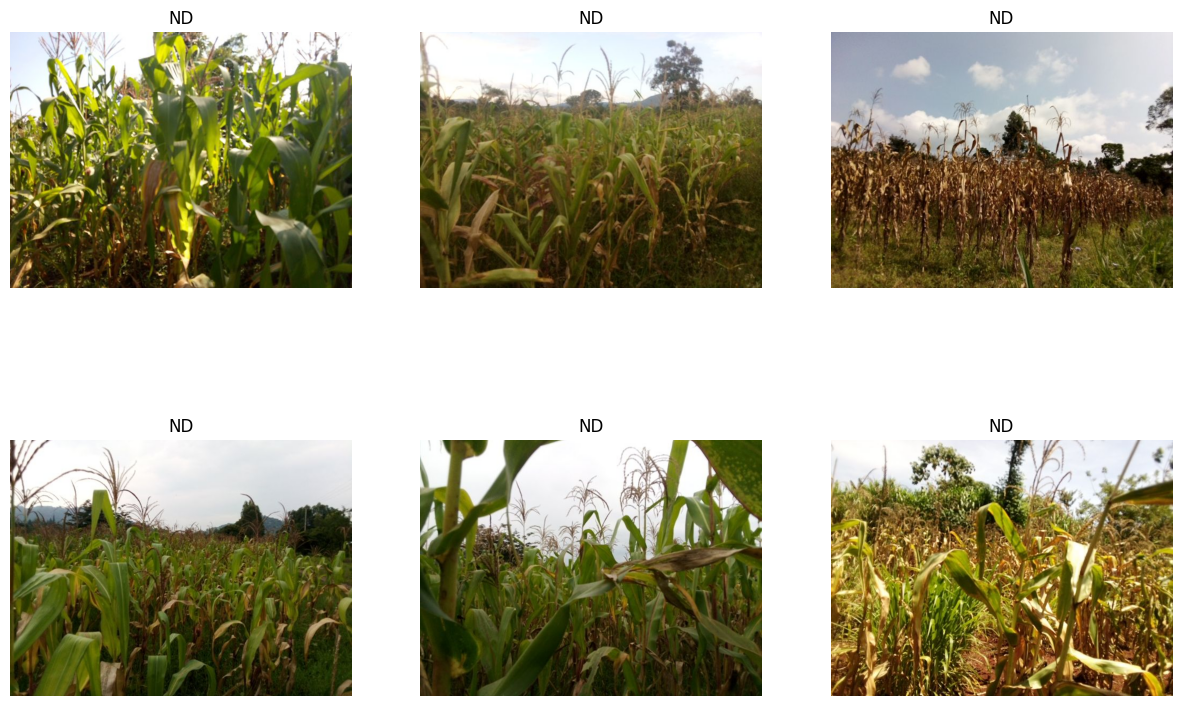

In [6]:

def plot_images(
    df: pd.DataFrame,
    n_samples: int,
    cat: str,
    seed: int,
    verbose: bool=False
):
    """Visualize a sample of images for a given damage category."""
    plot_list = df[(df["damage"] == cat)].sample(n_samples, random_state=seed)["image"].tolist()
    if verbose:
        print(f"Sampled Image IDs:\n{plot_list}")

    labels = [cat for i in range(len(plot_list))]
    size = np.sqrt(n_samples)
    if int(size) * int(size) < n_samples:
        size = int(size) + 1

    plt.figure(figsize=(15, 15))
    for idx, (image_id, label) in enumerate(zip(plot_list, labels)):
        plt.subplot(size, size, idx + 1)
        image = cv2.imread(image_id)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.imshow(image)
        plt.title(label, fontsize=12)
        plt.axis("off")

    plt.show()

plot_images(df=train_df, n_samples=6, cat="ND", seed=np.random.randint(100), verbose=True)

In [7]:
# get sample barren land image
train_df[train_df["image"] == "./clf_data/images/0a3e75b9a02f6568189bd0d25773be781553e8e7.jpg"]

ID damage                                      filename  \
15629  ID_BZ7GD0      G  0a3e75b9a02f6568189bd0d25773be781553e8e7.jpg   

                                                   image  
15629  ./clf_data/images/0a3e75b9a02f6568189bd0d25773...

In [8]:
## gzip compress
compression_ratios = []
compressed_data_sizes = []
#base64_compressed_size = []
"""
for image_path in train_df["image"]:
	with open(image_path, 'rb') as f:
		raw_image = f.read()
		compressed_image = gzip.compress(raw_image)
		#compressed_image_base64 = base64.b64encode(compressed_image).decode("utf-8") #bytestring
		compressed_data_sizes.append(len(compressed_image))
		#base64_compressed_size.append(len(compressed_image_base64))
		compression_ratios.append(len(compressed_image) / len(raw_image))
"""
train_embeddings = np.load("./embeddings/swin_large_patch4_window12_384_train_embeddings_mean.npy")

model = KNeighborsClassifier(n_neighbors=3)
model.fit(train_embeddings, train_df["damage"].values)


KNeighborsClassifier(n_neighbors=3)

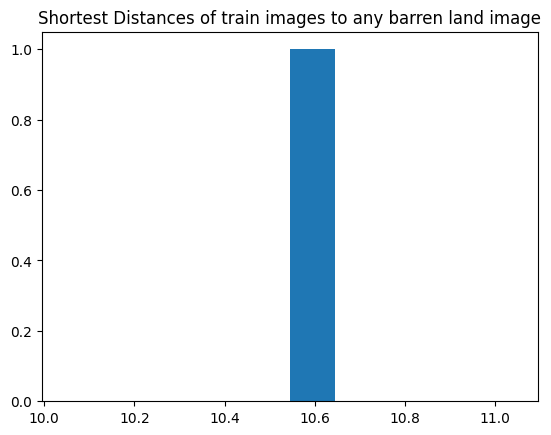

In [9]:
## drop barren land images
_distances, _indices = model.kneighbors(train_embeddings[15629].reshape(1, -1))
_distances, _indices = _distances[:, 1:], _indices[:, 1:]
_mm = np.min(_distances, axis=1) #min distances
_idx = np.where((_mm < 150))[0] # nearest neighbor matched indices
plt.title('Shortest Distances of train images to any barren land image')
plt.hist(_mm)
plt.show()

In [10]:
len(_indices), len(_distances), _idx, _indices

(1, 1, array([0]), array([[20669,  3831]]))

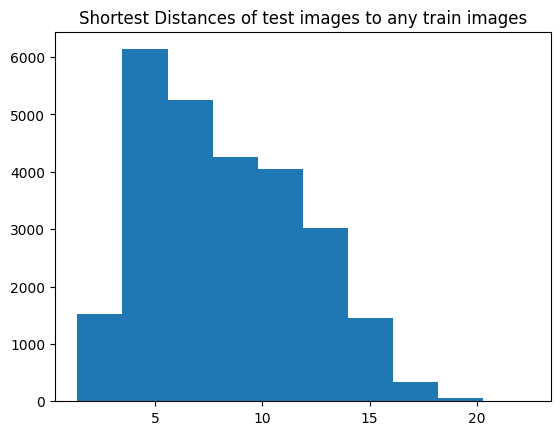

In [11]:
## compute pairwise distances to determine nearest neighbor
distances, indices = model.kneighbors(train_embeddings)
distances, indices = distances[:, 1:], indices[:, 1:]
mm = np.min(distances, axis=1) #min distances
idx = np.where((mm < 3))[0] # nearest neighbor matched indices
plt.title('Shortest Distances of test images to any train images')
plt.hist(mm)
plt.show()

In [12]:
len(idx), len(distances), len(indices)

(669, 26068, 26068)

In [13]:
c = [] # store duplicate IDs

for k in idx:
    t1 = train_df['damage'].iloc[k]
    t2 = train_df["damage"].iloc[int(indices[k,0])]
    #train_df["damage"].iloc[int(indices[k,0])] = train_df['damage'].iloc[k]
    if t1 == t2:
        continue
    else:
        c.append(train_df.loc[int(indices[k,0]), "ID"])
        c.append(train_df['ID'].iloc[k])
    """
    if t1 != t2:
        plt.figure(figsize=(10,5))
        
        plt.subplot(1,2,1)
        img = cv2.imread(train_df.loc[k, "image"])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img)
        plt.title(f"Train image - Target = {t1} \n {train_df['ID'].iloc[k]}")

        plt.subplot(1,2,2)
        img = cv2.imread(train_df.loc[int(indices[k,0]), "image"])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img)
        
        plt.title(f"Train dupe image - Target = {t2}\n {train_df.loc[int(indices[k,0]), 'ID']}")
        
        plt.show()

    continue
    """

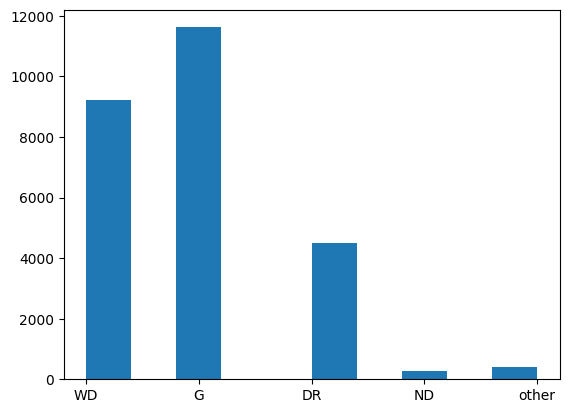

In [14]:
# target distributioin
plt.hist(train_df["damage"]);

In [15]:
train_df = train_df[train_df["ID"].apply(lambda x: x not in set(c))].reset_index(drop=True)
train_df.shape

(25924, 4)

In [16]:
train_df["damage"].value_counts()

damage
G        11566
WD        9201
DR        4492
other      403
ND         262
Name: count, dtype: int64

In [17]:
damage_enc = LabelEncoder()
train_df["damage"] = damage_enc.fit_transform(train_df["damage"])
## create folds
skfold = StratifiedKFold(n_splits=Config.n_folds, shuffle=True, random_state=Config.seed)
for i, (train_idx, val_idx) in enumerate(skfold.split(train_df, train_df["damage"]), 1):
	train_df.loc[val_idx, "fold"] = int(i)

train_df.head()

ID  damage                                      filename  \
0  ID_UBHORS       3  d036341be8d6cd59851cb80bcc9a70cc9fbdba30.jpg   
1  ID_9DSOLZ       1  9ea16180c50d0cd539897eefbfe585314e50a56b.jpg   
2  ID_JHLM0G       1  b6b564844041bc68774a553eaf43d61654657dd9.jpg   
3  ID_ATREIJ       0  62262859f0cd411aaf484082ed3ef0b625bc452a.jpg   
4  ID_L2GAD6       1  03b6e2a8ace7cb611eccba289f3c83d9bd497584.jpg   

                                               image  fold  
0  ./clf_data/images/d036341be8d6cd59851cb80bcc9a...   2.0  
1  ./clf_data/images/9ea16180c50d0cd539897eefbfe5...   4.0  
2  ./clf_data/images/b6b564844041bc68774a553eaf43...   5.0  
3  ./clf_data/images/62262859f0cd411aaf484082ed3e...   5.0  
4  ./clf_data/images/03b6e2a8ace7cb611eccba289f3c...   4.0

In [18]:
train_df["fold"].value_counts()

fold
2.0    5185
4.0    5185
3.0    5185
1.0    5185
5.0    5184
Name: count, dtype: int64

### Embeddings

In [19]:
timm.list_models()
# "vgg19", "tf_mobilenetv3_large_minimal_100"
# "vgg19_bn" "resnet50", "efficientnet_b3", "efficientnet_b4"
#  'resnext50_32x4d',
# 'resnext50d_32x4d', #'convnextv2_large', 'beit_large_patch16_384'
# 'resnext101_32x32d',

['bat_resnext26ts',
 'beit_base_patch16_224',
 'beit_base_patch16_384',
 'beit_large_patch16_224',
 'beit_large_patch16_384',
 'beit_large_patch16_512',
 'beitv2_base_patch16_224',
 'beitv2_large_patch16_224',
 'botnet26t_256',
 'botnet50ts_256',
 'caformer_b36',
 'caformer_m36',
 'caformer_s18',
 'caformer_s36',
 'cait_m36_384',
 'cait_m48_448',
 'cait_s24_224',
 'cait_s24_384',
 'cait_s36_384',
 'cait_xs24_384',
 'cait_xxs24_224',
 'cait_xxs24_384',
 'cait_xxs36_224',
 'cait_xxs36_384',
 'coat_lite_medium',
 'coat_lite_medium_384',
 'coat_lite_mini',
 'coat_lite_small',
 'coat_lite_tiny',
 'coat_mini',
 'coat_small',
 'coat_tiny',
 'coatnet_0_224',
 'coatnet_0_rw_224',
 'coatnet_1_224',
 'coatnet_1_rw_224',
 'coatnet_2_224',
 'coatnet_2_rw_224',
 'coatnet_3_224',
 'coatnet_3_rw_224',
 'coatnet_4_224',
 'coatnet_5_224',
 'coatnet_bn_0_rw_224',
 'coatnet_nano_cc_224',
 'coatnet_nano_rw_224',
 'coatnet_pico_rw_224',
 'coatnet_rmlp_0_rw_224',
 'coatnet_rmlp_1_rw2_224',
 'coatnet_rmlp_1_r

In [20]:
#vit_model = AutoModel.from_pretrained("./vit-base-patch16-224-in21k-finetuned-cassava/")
#vit_processor = ViTImageProcessor.from_pretrained("./vit-base-patch16-224-in21k-finetuned-cassava/")
swin_model = timm.create_model(
    "swin_large_patch4_window12_384", #"beit_large_patch16_384", #"vit_base_patch16_siglip_384"
    pretrained=True,
    num_classes=0,  # remove classifier nn.Linear
)
swin_model

/Users/smugisha/Downloads/cgiar/env/lib/python3.11/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3527.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


SwinTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 192, kernel_size=(4, 4), stride=(4, 4))
    (norm): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
  )
  (layers): Sequential(
    (0): SwinTransformerStage(
      (downsample): Identity()
      (blocks): Sequential(
        (0): SwinTransformerBlock(
          (norm1): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
          (attn): WindowAttention(
            (qkv): Linear(in_features=192, out_features=576, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=192, out_features=192, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
            (softmax): Softmax(dim=-1)
          )
          (drop_path1): Identity()
          (norm2): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=192, out_features=768, bias=True)
            (act): GELU(approximate='none')
            (

In [21]:
data_config = timm.data.resolve_model_data_config(swin_model)
data_config

{'input_size': (3, 384, 384),
 'interpolation': 'bicubic',
 'mean': (0.485, 0.456, 0.406),
 'std': (0.229, 0.224, 0.225),
 'crop_pct': 1.0,
 'crop_mode': 'center'}

In [22]:
#_transforms = [
#	transforms.ToTensor(),
#	transforms.RandomResizedCrop(size=(224, 224)),
#    transforms.RandomHorizontalFlip(p=0.5),
#    transforms.ToDtype(torch.float32, scale=True),
#    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
#]

img = PIL.Image.open(train_df.loc[1, "image"])
#inputs = vit_processor(img, return_tensors="pt").to(Config.device)
#with torch.no_grad():
#	vit_model.to(Config.device)
#	vit_model.eval()
#	emb = torch.mean(vit_model(**inputs).last_hidden_state, 1)
#emb.shape, emb
data_config = timm.data.resolve_model_data_config(swin_model)
transforms = timm.data.create_transform(**data_config, is_training=False)
#transforms(image).squeeze(0)
data_config, transforms

({'input_size': (3, 384, 384),
  'interpolation': 'bicubic',
  'mean': (0.485, 0.456, 0.406),
  'std': (0.229, 0.224, 0.225),
  'crop_pct': 1.0,
  'crop_mode': 'center'},
 Compose(
     Resize(size=384, interpolation=bicubic, max_size=None, antialias=warn)
     CenterCrop(size=(384, 384))
     ToTensor()
     Normalize(mean=tensor([0.4850, 0.4560, 0.4060]), std=tensor([0.2290, 0.2240, 0.2250]))
 ))

In [23]:
torch.manual_seed(Config.seed)
torch.mps.manual_seed(Config.seed)
torch.backends.mps.deterministic=True

### Extract Image Embeddings

Extract image embeddings per damage category using different pretrained vision models

#### Embeddings + classical models

In [24]:
class ImageDataset(Dataset):
	"""CGIAR maize dataset."""
	def __init__(self, data_df, processor, model, timm_data_cfg=False, verbose=False):
		self.data_df = data_df
		self.processor = processor
		self.model = model
		self.timm_cfg = timm_data_cfg

	def __len__(self):
		return self.data_df.shape[0]

	def __getitem__(self, idx):
		image_path = self.data_df.loc[idx, "image"]
		image = PIL.Image.open(image_path).convert("RGB")
		
		if self.timm_cfg:
			# get model specific transforms (normalization, resize)
			data_config = timm.data.resolve_model_data_config(self.model)
			transforms = timm.data.create_transform(**data_config, is_training=False)
			return transforms(image).squeeze(0)
		else:
			image = self.processor(image, return_tensors="pt").pixel_values[0]
			return image


def get_dataloaders(train_df, test_df, processor, model, batch_size, timm_data_cfg=False):
	"""Get ImageDataset data generators."""
	train_df = train_df[["image"]]
	test_df = test_df[["image"]]
	train_dataset = ImageDataset(train_df, processor, model, timm_data_cfg)
	test_dataset = ImageDataset(test_df, processor, model, timm_data_cfg)
	# create dataloaders
	train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
	test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

	return train_dataloader, test_dataloader


def embeddings_to_disk(embeddings: np.ndarray, filename: str):
	"""Save embeddings to disk as numpy arrays."""
	np.save(filename+".npy", embeddings)
	return 


def get_embeddings(model, data_loader, batch_size, device, is_timm_model=False, aggregate="mean", split="train", verbose=True):
	"""Extract embeddings from input model."""
	model = model.to(device)
	model.eval()
	if split=="train":
		train_image_features = []
		for batch in tqdm(data_loader, total=len(data_loader)):
			if is_timm_model:
				with torch.no_grad():
					output = model.forward_features(batch.to(device))
					image_embeddings = model.forward_head(output, pre_logits=True)
			else:
				with torch.no_grad():
					image_embeddings = model(batch.to(device)).last_hidden_state
					if aggregate == "max":
						image_embeddings = torch.max(image_embeddings, 1)
					else: #"mean"
						image_embeddings = torch.mean(image_embeddings, 1)

			image_embeddings = image_embeddings.squeeze(0).detach().cpu().numpy()
			train_image_features.extend(image_embeddings)
		train_image_features = np.array(train_image_features)
		if verbose:
			print(f"Train embeddings shape: {train_image_features.shape}")
		
		return train_image_features

	else: # split == "test"
		test_image_features = []
		for batch in tqdm(data_loader, total=len(data_loader)):
			if is_timm_model:
				with torch.no_grad():
					output = model.forward_features(batch.to(device))
					image_embeddings = model.forward_head(output, pre_logits=True)
			else:
				with torch.no_grad():
					image_embeddings = model(batch.to(device)).last_hidden_state
					if aggregate == "max":
						image_embeddings = torch.max(image_embeddings, 1)
					else:
						image_embeddings = torch.mean(image_embeddings, 1)
			
			image_embeddings = image_embeddings.squeeze(0).detach().cpu().numpy()
			test_image_features.extend(image_embeddings)

		test_image_features = np.asarray(test_image_features)
		if verbose:
			print(f"Test embeddings shape: {test_image_features.shape}")

		return test_image_features

In [25]:
# Steps run only once embeddings saved to disk
# uncomment to rerun once and load & use saved embeddings on disk for subsequent runs
def fetch_store_embeddings(models: dict, train_df, test_df):
	"""Extract and save embeddings to disk.""" 
	for key, model in models.items():
		print(f"================ Extracting Image embeddings from {key} model =========================")
		train_dataloader, test_dataloader = get_dataloaders(train_df, test_df, None, model, Config.batch_size, timm_data_cfg=True)

		## aggregate arg below should be set to "mean" if mean of embeddings are or "max" for max embeddings needed

		train_embeddings = get_embeddings(model, train_dataloader, Config.batch_size, Config.device, is_timm_model=True, aggregate="mean", split="train")
		#test_embeddings = get_embeddings(model, test_dataloader, Config.batch_size, Config.device, is_timm_model=True, aggregate="mean", split="test")

		#Save embeddings to disk
		if not os.path.isdir("./embeddings"):
			os.mkdir("./embeddings")
			
		embeddings_to_disk(train_embeddings, f"./embeddings/{key}_train_embeddings_mean")
		#embeddings_to_disk(test_embeddings, f"./embeddings/{key}_test_embeddings_mean")
		del train_embeddings
		#del test_embeddings
		del train_dataloader
		del test_dataloader
		gc.collect()

models = {"swin_large_patch4_window12_384_dedupe_k<3": swin_model}
#fetch_store_embeddings(models, train_df, test_df)

In [26]:
train_features = np.load("./embeddings/swin_large_patch4_window12_384_dedupe_k<3_train_embeddings_mean.npy")
test_features = np.load("./embeddings/swin_large_patch4_window12_384_test_embeddings_mean.npy")
print(train_features.shape, test_features.shape)

(25924, 1536) (8663, 1536)


In [27]:
train_df = train_df.drop(["ID", "image", "filename"], axis=1)
test_ids = test_df["ID"]
test_df = test_df.drop(["ID", "image", "filename"], axis=1)

In [47]:
## model training
def upsample(df: pd.DataFrame):
	"""upsample minority classes in dataframe."""
	minority_classes = [4, 2] # other, ND
	minority_mask = df["damage"].isin(minority_classes)
	sampled_df = df[minority_mask].sample(frac=5.0, replace=True, random_state=Config.seed)
	df_upsampled = pd.concat([df, sampled_df], axis=0)

	return df_upsampled


scores = []
predictions = []

for fold in range(1, Config.n_folds+1):
	print(f"======= Fold {fold}========")
	df_train = train_df[train_df["fold"] != fold]
	#df_train = upsample(df_train)
	df_val = train_df[train_df["fold"] == fold]
	train_embeddings = train_features[list(df_train.index), :]
	train_embeddings = np.concatenate([train_embeddings, df_train.iloc[:, 2:].values], axis=1)
	target = df_train["damage"]
	val_target = df_val["damage"]

	val_embeddings = train_features[list(df_val.index), :]
	val_embeddings = np.concatenate([val_embeddings, df_val.iloc[:, 2:].values], axis=1)
	
	print(f"train_shape: {train_embeddings.shape}\nval_shape: {val_embeddings.shape}\ntest_shape: {test_features.shape}")

	xgb_model = xgb.XGBClassifier(
		n_estimators=250, #250
		max_depth=5,
		max_leaves=150,
		objective="multi:softmax",
		num_classes=5,
		eval_metric=["mlogloss"],
		colsample_bytree=0.9,
		subsample=0.9,
		#booster="gbtree",
		#importance_type="gain",
		reg_alpha=1.5,
		learning_rate=0.143,
		random_state=Config.seed
	)
	xgb_model.fit(train_embeddings, target)
	val_preds = xgb_model.predict_proba(val_embeddings)
	test_preds = xgb_model.predict_proba(test_features)
	score = log_loss(val_target, val_preds)
	scores.append(score)
	print(f"Fold {fold} logloss: {score}")
	predictions.append(test_preds)


======= Fold 1========
train_shape: (20739, 1536)
val_shape: (5185, 1536)
test_shape: (8663, 1536)


/Users/smugisha/Downloads/cgiar/env/lib/python3.11/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/smugisha/Downloads/cgiar/env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:27:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "num_classes" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 1 logloss: 0.6690471551268876
======= Fold 2========
train_shape: (20739, 1536)
val_shape: (5185, 1536)
test_shape: (8663, 1536)


/Users/smugisha/Downloads/cgiar/env/lib/python3.11/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/smugisha/Downloads/cgiar/env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:28:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "num_classes" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 2 logloss: 0.6731640193044229
======= Fold 3========
train_shape: (20739, 1536)
val_shape: (5185, 1536)
test_shape: (8663, 1536)


/Users/smugisha/Downloads/cgiar/env/lib/python3.11/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/smugisha/Downloads/cgiar/env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:29:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "num_classes" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 3 logloss: 0.6767779136051347
======= Fold 4========
train_shape: (20739, 1536)
val_shape: (5185, 1536)
test_shape: (8663, 1536)


/Users/smugisha/Downloads/cgiar/env/lib/python3.11/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/smugisha/Downloads/cgiar/env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:30:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "num_classes" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 4 logloss: 0.6643681553398979
======= Fold 5========
train_shape: (20740, 1536)
val_shape: (5184, 1536)
test_shape: (8663, 1536)


/Users/smugisha/Downloads/cgiar/env/lib/python3.11/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/smugisha/Downloads/cgiar/env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:31:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "num_classes" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 5 logloss: 0.6561104580456143


In [48]:
np.mean(scores)

0.6678935402843915

In [46]:
sub_df = pd.DataFrame()
sub_df["ID"] = test_ids
sub_df[damage_enc.inverse_transform(xgb_model.classes_)] = np.mean(predictions, 0)
sub_df.to_csv("sub_xgb_swin_large_patch4_window12_384_dedup_knn<3.csv", index=False)
sub_df.head()

ID        DR         G        ND        WD     other
0  ID_QW9GQM  0.003589  0.632865  0.000435  0.361803  0.001309
1  ID_G9VPQ9  0.050411  0.640135  0.003257  0.044651  0.261547
2  ID_QIMIEM  0.001460  0.696390  0.000159  0.301418  0.000573
3  ID_TSINUQ  0.002208  0.863323  0.000104  0.132854  0.001512
4  ID_I7OOHH  0.301098  0.263401  0.005790  0.428501  0.001211

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=3, random_state=Config.seed, n_iter=15000, metric="cosine")
embs = tsne.fit_transform(train_features)
test_embs = tsne.fit_transform(test_features)

In [ ]:
train_df = pd.concat([train_df, pd.DataFrame(embs)], axis=1).reset_index(drop=True)
train_df["damage"] = damage_enc.inverse_transform(train_df["damage"])
train_df.head()

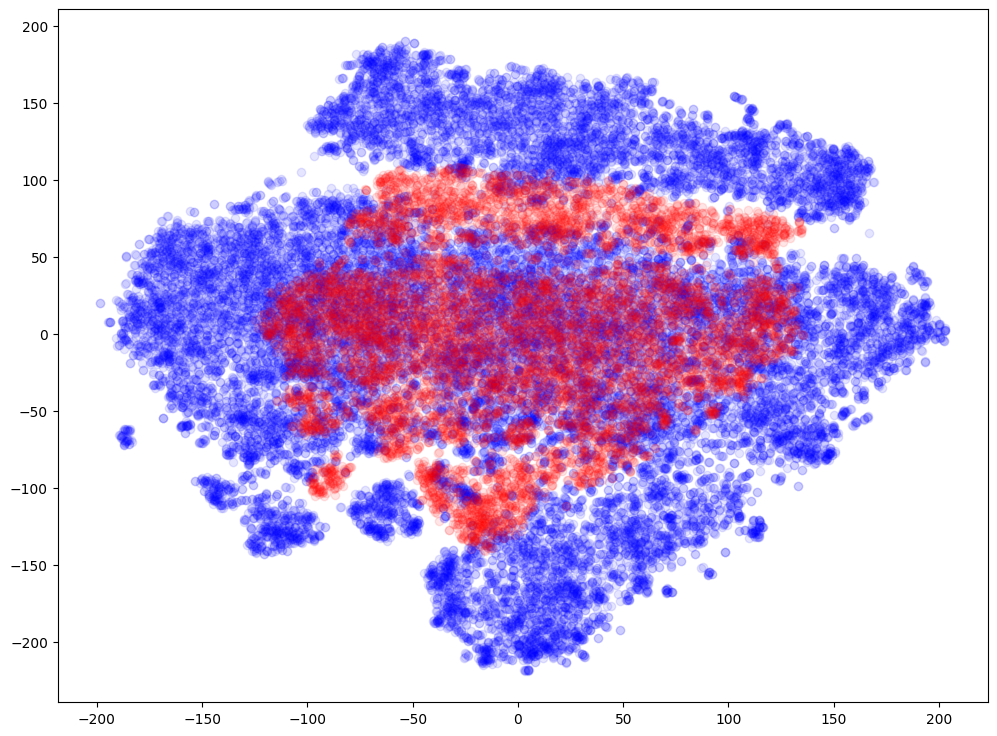

In [63]:
## swin_large_patch4_window12_384 >> ## vit_base_patch16_siglip_384 
fig, ax = plt.subplots(figsize=(12,9))
X = embs[:, 0]
Y = embs[:, 1]
X_test = test_embs[:, 0]
Y_test = test_embs[:, 1]
ax.scatter(X, Y, alpha=0.1, c='blue')
ax.scatter(X_test, Y_test, alpha=0.1, c='red')

In [ ]:
train_df = pd.concat([train_df, pd.DataFrame(embs)], axis=1).reset_index(drop=True)
train_df["damage"] = damage_enc.inverse_transform(train_df["damage"])
train_df.head()

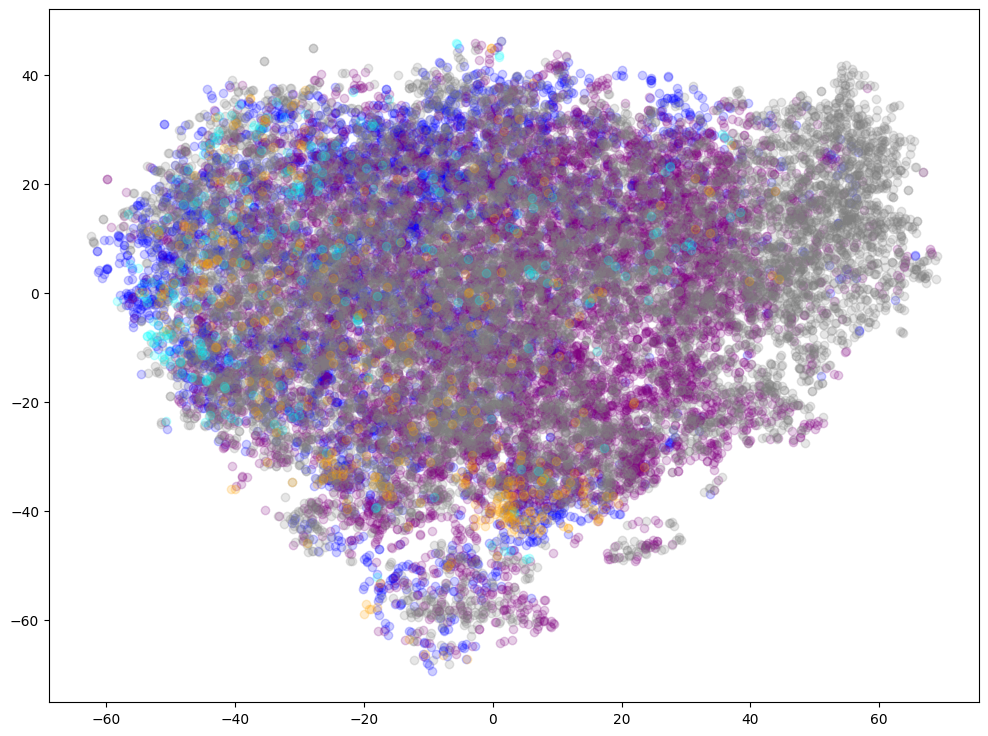

In [123]:
fig, ax = plt.subplots(figsize=(12,9))
X = train_df[train_df["damage"] == "DR"].loc[:, 0]
Y = train_df[train_df["damage"] == "DR"].loc[:, 1]
X1 = train_df[train_df["damage"] == "WD"].loc[:, 0]
Y1 = train_df[train_df["damage"] == "WD"].loc[:, 1]
X2 = train_df[train_df["damage"] == "G"].loc[:, 0]
Y2 = train_df[train_df["damage"] == "G"].loc[:, 1]
X3 = train_df[train_df["damage"] == "ND"].loc[:, 0]
Y3 = train_df[train_df["damage"] == "ND"].loc[:, 1]
X4 = train_df[train_df["damage"] == "other"].loc[:, 0]
Y4 = train_df[train_df["damage"] == "other"].loc[:, 1]
ax.scatter(X, Y, alpha=0.1, c="blue") #DR
ax.scatter(X1, Y1, alpha=0.1, c="purple") # WD
ax.scatter(X2, Y2, alpha=0.1, c="gray")  #G
ax.scatter(X3, Y3, alpha=0.1, c="cyan") # ND
ax.scatter(X4, Y4, alpha=0.1, c="orange") # other

/Users/smugisha/Downloads/cgiar/env/lib/python3.11/site-packages/matplotlib/collections.py:996: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


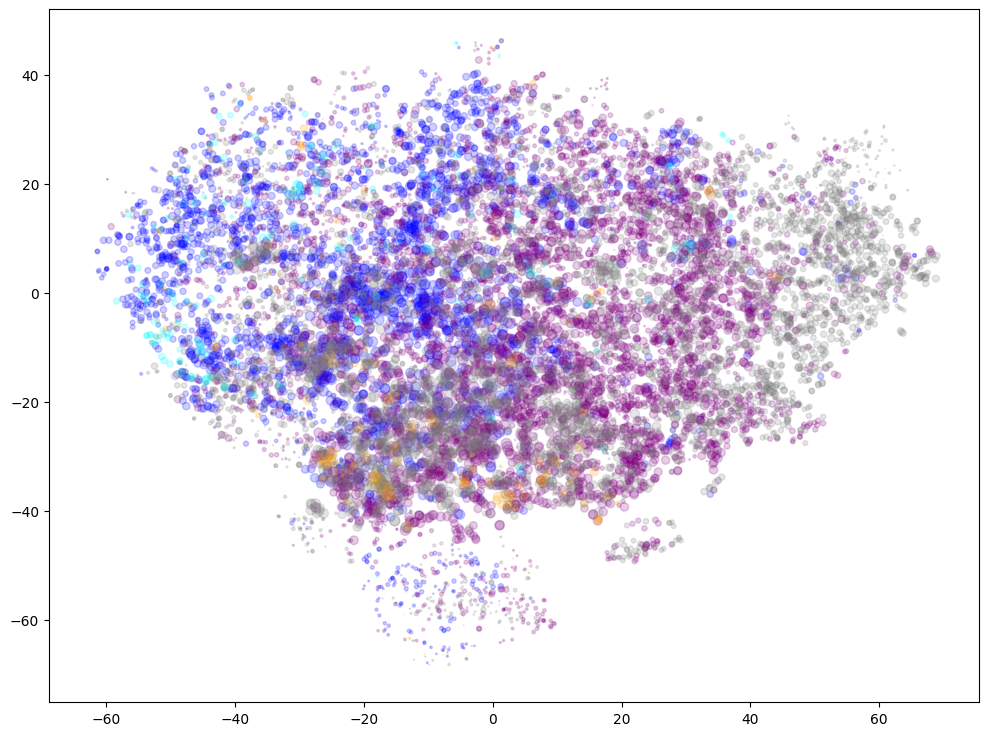

In [124]:
fig, ax = plt.subplots(figsize=(12,9))
X = train_df[train_df["damage"] == "DR"].loc[:, 0]
Y = train_df[train_df["damage"] == "DR"].loc[:, 1]
Z = train_df[train_df["damage"] == "DR"].loc[:, 2]
X1 = train_df[train_df["damage"] == "WD"].loc[:, 0]
Y1 = train_df[train_df["damage"] == "WD"].loc[:, 1]
Z1 = train_df[train_df["damage"] == "WD"].loc[:, 2]
X2 = train_df[train_df["damage"] == "G"].loc[:, 0]
Y2 = train_df[train_df["damage"] == "G"].loc[:, 1]
Z2 = train_df[train_df["damage"] == "G"].loc[:, 2]
X3 = train_df[train_df["damage"] == "ND"].loc[:, 0]
Y3 = train_df[train_df["damage"] == "ND"].loc[:, 1]
Z3 = train_df[train_df["damage"] == "ND"].loc[:, 2]
X4 = train_df[train_df["damage"] == "other"].loc[:, 0]
Y4 = train_df[train_df["damage"] == "other"].loc[:, 1]
Z4 = train_df[train_df["damage"] == "other"].loc[:, 2]
ax.scatter(X, Y, Z, alpha=0.1, c="blue") #DR
ax.scatter(X1, Y1, Z1, alpha=0.1, c="purple") # WD
ax.scatter(X2, Y2, Z2, alpha=0.1, c="gray")  #G
ax.scatter(X3, Y3, Z3, alpha=0.1, c="cyan") # ND
ax.scatter(X4, Y4, Z4, alpha=0.1, c="orange") # other

In [ ]:
# ichi-go ichi-e